# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0")    # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                                std=[0.20,0.20,0.20])
                       ]))
data_test = dset.SVHN('./data/', split='test',
                      download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                      ]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [6]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),    # input 3*32*32, output 64*32*32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    # output 64*8*8

            nn.Conv2d(64, 64, 3, padding=1),    # output 64*8*8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    # output 64*2*2

            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(num_epochs):
        model.train()    # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        
        print(f'Epoch {epoch} '
              f'Average loss: {ave_loss:.4f} '
              f'Train accuracy: {train_accuracy:.4f} '
              f'Val accuracy: {val_accuracy:.4f}')
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()    # Evaluation mode
    acc_history = []

    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        pred_prob = model(x_gpu)
        pred_labels = pred_prob.argmax(dim=1)
        accuracy = sum([1 for pred, test in zip(pred_labels, y_gpu) if pred == test]) / batch_size
        acc_history.append(accuracy)

    return np.mean(acc_history)

In [8]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 Average loss: 1.4375 Train accuracy: 0.5206 Val accuracy: 0.7595
Epoch 1 Average loss: 0.7046 Train accuracy: 0.7858 Val accuracy: 0.7935
Epoch 2 Average loss: 0.5417 Train accuracy: 0.8420 Val accuracy: 0.8499
Epoch 3 Average loss: 0.5057 Train accuracy: 0.8518 Val accuracy: 0.8483
Epoch 4 Average loss: 0.4527 Train accuracy: 0.8694 Val accuracy: 0.8570


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', download=True, transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:1230: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


Using downloaded and verified file: ./train_32x32.mat


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

Using downloaded and verified file: ./train_32x32.mat


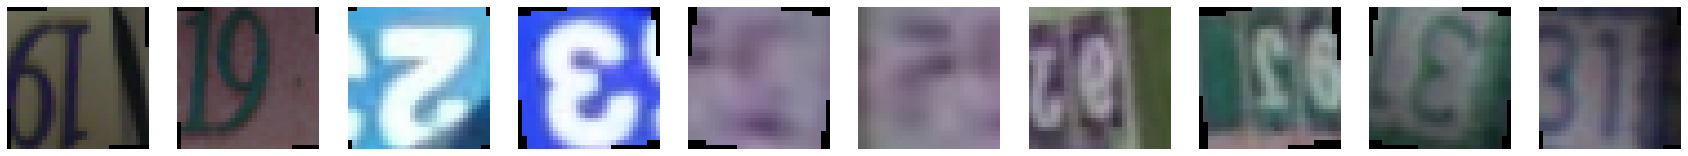

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', download=True, transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

Using downloaded and verified file: ./train_32x32.mat


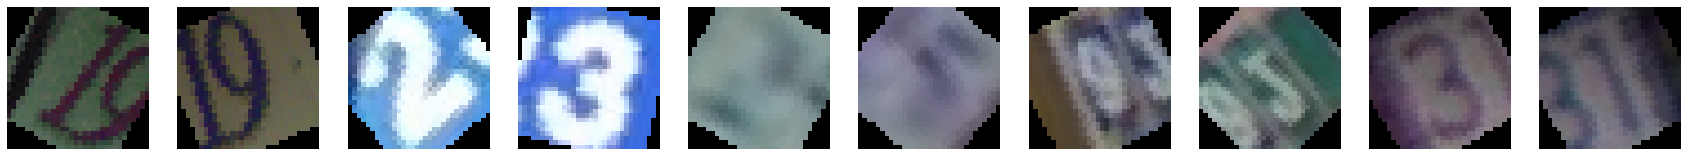

In [25]:
# TODO:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomAffine(degrees=(-45, 45)),                         
])

# TODO create new instances of loaders with the augmentations you chose

data_aug_train = dset.SVHN('./', download=True, transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_train):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [33]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomAffine(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                         std=[0.20,0.20,0.20])
])

data_aug_train = dset.SVHN('./', download=True, transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                               sampler=train_sampler)


Using downloaded and verified file: ./train_32x32.mat


In [34]:
# Finally, let's train with augmentations!
nn_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),    # input 3*32*32, output 64*32*32
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),    # output 64*8*8

    nn.Conv2d(64, 64, 3, padding=1),    # output 64*8*8
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),    # output 64*2*2

    Flattener(),
    nn.Linear(64*2*2, 10),
)
# Note we shouldn't use augmentations on validation
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 10)

Epoch 0 Average loss: 1.8405 Train accuracy: 0.3642 Val accuracy: 0.6489
Epoch 1 Average loss: 1.1364 Train accuracy: 0.6284 Val accuracy: 0.7377
Epoch 2 Average loss: 0.9099 Train accuracy: 0.7091 Val accuracy: 0.7596
Epoch 3 Average loss: 0.8634 Train accuracy: 0.7270 Val accuracy: 0.7697
Epoch 4 Average loss: 0.7922 Train accuracy: 0.7521 Val accuracy: 0.7766
Epoch 5 Average loss: 0.7777 Train accuracy: 0.7564 Val accuracy: 0.7950
Epoch 6 Average loss: 0.7366 Train accuracy: 0.7710 Val accuracy: 0.7987
Epoch 7 Average loss: 0.7296 Train accuracy: 0.7739 Val accuracy: 0.8072
Epoch 8 Average loss: 0.7181 Train accuracy: 0.7784 Val accuracy: 0.8104
Epoch 9 Average loss: 0.7104 Train accuracy: 0.7800 Val accuracy: 0.8110


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [35]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),    # input 1*32*32, output 6*28*28
    nn.Tanh(),

    nn.AvgPool2d(2, stride=2),    # output 6*14*14
    nn.Tanh(),

    nn.Conv2d(6, 16, 5),    # output 16*10*10
    nn.Tanh(),

    nn.AvgPool2d(2, stride=2),    # output 16*5*5
    nn.Tanh(),

    Flattener(),
    nn.Linear(16*5*5, 120),
    nn.Tanh(),

    nn.Linear(120, 84),
    nn.Tanh(),

    nn.Linear(84, 10),
    nn.Softmax(dim=1)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [36]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, 10)

Epoch 0 Average loss: 2.2772 Train accuracy: 0.1787 Val accuracy: 0.1871
Epoch 1 Average loss: 2.2503 Train accuracy: 0.1995 Val accuracy: 0.2381
Epoch 2 Average loss: 2.1841 Train accuracy: 0.2727 Val accuracy: 0.3017
Epoch 3 Average loss: 2.1226 Train accuracy: 0.3333 Val accuracy: 0.3597
Epoch 4 Average loss: 2.0835 Train accuracy: 0.3792 Val accuracy: 0.3985
Epoch 5 Average loss: 2.0568 Train accuracy: 0.4104 Val accuracy: 0.4147
Epoch 6 Average loss: 2.0367 Train accuracy: 0.4287 Val accuracy: 0.4347
Epoch 7 Average loss: 2.0257 Train accuracy: 0.4394 Val accuracy: 0.4441
Epoch 8 Average loss: 2.0177 Train accuracy: 0.4465 Val accuracy: 0.4475
Epoch 9 Average loss: 2.0133 Train accuracy: 0.4498 Val accuracy: 0.4507


# Подбор гиперпараметров

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [38]:
# add lr scheduler, batch normalization, Adam optimization

nn_model = nn.Sequential(
    nn.Conv2d(3, 32, 7, padding=5),    # input 3*32*32, output 32*32*32
    nn.ReLU(inplace=True),
    nn.MaxPool2d(4),    # output 32*8*8
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 64, 5, padding=3),    # output 64*8*8
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),    # output 64*4*4
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, 3, padding=1),    # output 128*4*4
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),    # output 128*2*2
    nn.BatchNorm2d(128),

    Flattener(),
    nn.Linear(128*2*2, 256),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(256),
    
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(128),
    
    nn.Linear(128, 10)
)

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 10)

Epoch 0 Average loss: 2.3285 Train accuracy: 0.1666 Val accuracy: 0.1619
Epoch 1 Average loss: 2.3165 Train accuracy: 0.1604 Val accuracy: 0.1433
Epoch 2 Average loss: 2.2538 Train accuracy: 0.1819 Val accuracy: 0.1908
Epoch 3 Average loss: 1.8089 Train accuracy: 0.3635 Val accuracy: 0.5676
Epoch 4 Average loss: 1.0601 Train accuracy: 0.6489 Val accuracy: 0.7598
Epoch 5 Average loss: 0.7914 Train accuracy: 0.7497 Val accuracy: 0.8022
Epoch 6 Average loss: 0.6435 Train accuracy: 0.7973 Val accuracy: 0.8193
Epoch 7 Average loss: 0.6007 Train accuracy: 0.8115 Val accuracy: 0.8335
Epoch 8 Average loss: 0.5849 Train accuracy: 0.8169 Val accuracy: 0.8279
Epoch 9 Average loss: 0.5315 Train accuracy: 0.8345 Val accuracy: 0.8433


In [14]:
# add lr scheduler, batch normalization, Adam optimization, LeakyReLU activation

nn_model = nn.Sequential(
    nn.Conv2d(3, 32, 7, padding=5),    # input 3*32*32, output 32*32*32
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2),    # output 32*16*16
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 64, 5, padding=3),    # output 64*16*16
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2),    # output 64*8*8
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, 3, padding=1),    # output 128*8*8
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2),    # output 128*4*4
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, 3, padding=1),    # output 256*4*4
    nn.LeakyReLU(inplace=True),
    nn.MaxPool2d(2),    # output 256*2*2
    nn.BatchNorm2d(256),
    
    Flattener(),
    nn.Linear(256*2*2, 512),
    nn.LeakyReLU(inplace=True),
    nn.BatchNorm1d(512),
    
    nn.Linear(512, 256),
    nn.LeakyReLU(inplace=True),
    nn.BatchNorm1d(256),
    
    nn.Linear(256, 10)
)

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-1)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Epoch 0 Average loss: 1.9841 Train accuracy: 0.3321 Val accuracy: 0.7102
Epoch 1 Average loss: 0.6576 Train accuracy: 0.8008 Val accuracy: 0.8513
Epoch 2 Average loss: 0.3738 Train accuracy: 0.8867 Val accuracy: 0.8815
Epoch 3 Average loss: 0.3431 Train accuracy: 0.8964 Val accuracy: 0.8828
Epoch 4 Average loss: 0.2461 Train accuracy: 0.9265 Val accuracy: 0.9033
Epoch 5 Average loss: 0.2165 Train accuracy: 0.9350 Val accuracy: 0.9117
Epoch 6 Average loss: 0.1470 Train accuracy: 0.9566 Val accuracy: 0.9193
Epoch 7 Average loss: 0.1159 Train accuracy: 0.9647 Val accuracy: 0.9197
Epoch 8 Average loss: 0.0641 Train accuracy: 0.9806 Val accuracy: 0.9211
Epoch 9 Average loss: 0.0430 Train accuracy: 0.9867 Val accuracy: 0.9189


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [15]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print(f'Final test accuracy: {test_accuracy:.4f}')

Final test accuracy: 0.9174
